# Problema 2 

Considere el conjunto de datos de fraudes realizados con tarjeta de creito en el siguiente link. 
Utilizando los metodos vistos en clase, encuentre el mejor modelo de clasificacion para el caso 
en estudio, si una transaccion es fraudulenta o no. Considere: 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('card_transdata.csv')

## Eliminación de información redundante 


Revsión de existencia de campos null en el archivo y tipo de datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Identificar datos duplicados

In [4]:
filas_duplicadas = df.duplicated()
print("Filas Duplicadas:")
print(len(df[filas_duplicadas]))

Filas Duplicadas:
0


In [5]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Busqueda de datos atipicos

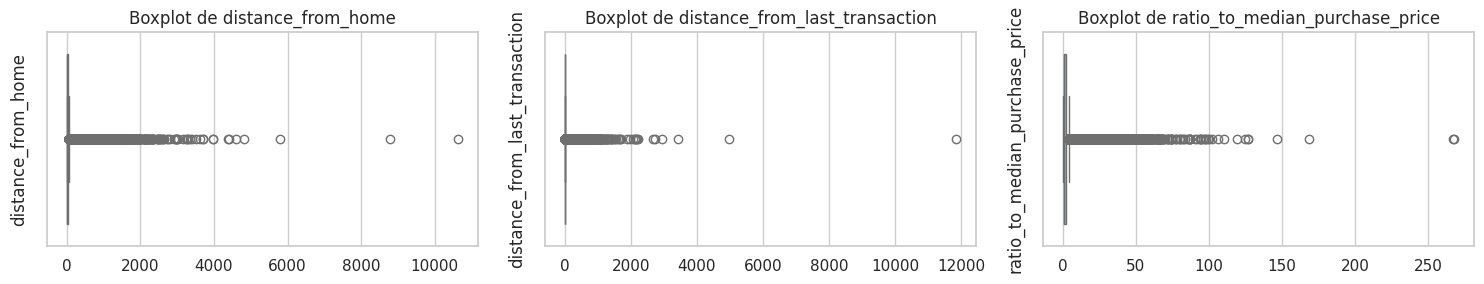

1000000


In [6]:
columnas_numericas = df.iloc[:, :3]
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, columna in enumerate(columnas_numericas.columns):
    sns.boxplot(x=columnas_numericas[columna], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {columna}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(columna)

plt.tight_layout()
plt.show()
print(len(df))

Eliminación de datos atipicos definiendo un umbral z=3 lo que representa bajo el supuesto de distirbución normal estándar el 99.7% de los datos

In [7]:
umbral_zscore = 3
z_scores = zscore(df.select_dtypes(include=['float64', 'int64']))
filas_outliers = (abs(z_scores) > umbral_zscore).any(axis=1)

# Eliminar filas con outliers
dataframe_sin_outliers = df[~filas_outliers]

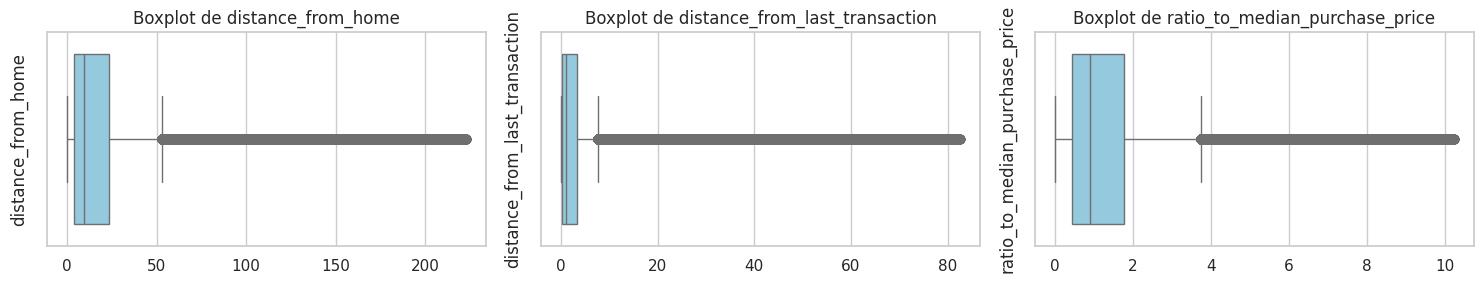

895305
queda el 0.895305 de los datos


In [8]:
columnas_numericas = dataframe_sin_outliers.iloc[:, :3]
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, columna in enumerate(columnas_numericas.columns):
    sns.boxplot(x=columnas_numericas[columna], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {columna}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(columna)

plt.tight_layout()
plt.show()
print(len(dataframe_sin_outliers))
pIQR = len(dataframe_sin_outliers) / len(df)
print(f"queda el {pIQR} de los datos")

Eliminación de datos atipicos por IQR que es más robusto frente a distribuciones no normales

In [9]:
columnas_numericas = df.iloc[:, :3]

# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = columnas_numericas.quantile(0.25)
Q3 = columnas_numericas.quantile(0.75)
IQR = Q3 - Q1

# Definir un umbral para identificar outliers basados en IQR
umbral_IQR = 1.5

# Identificar filas con outliers
mascara_outliers = ((columnas_numericas < (Q1 - umbral_IQR * IQR)) | (columnas_numericas > (Q3 + umbral_IQR * IQR))).any(axis=1)

# Eliminar filas con outliers
dataframe_sin_outliers_IQR = df[~mascara_outliers]

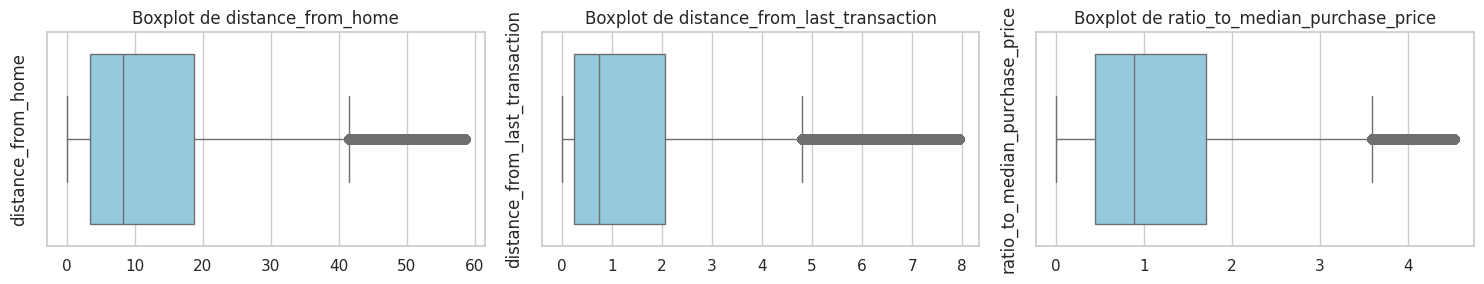

718750
queda el 0.71875 de los datos


In [10]:
columnas_numericas_IQR = dataframe_sin_outliers_IQR.iloc[:, :3]
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
for i, columna in enumerate(columnas_numericas_IQR.columns):
    sns.boxplot(x=columnas_numericas_IQR[columna], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {columna}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(columna)

plt.tight_layout()
plt.show()
print(len(dataframe_sin_outliers_IQR))
pIQR = len(dataframe_sin_outliers_IQR) / len(df)
print(f"queda el {pIQR} de los datos")

## Selección de variables 



Estandarizamos la data sin atipicos

In [11]:
# Selecciona las primeras tres columnas que deseas estandarizar
columnas_a_estandarizar = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

# Crea el objeto StandardScaler
scaler = StandardScaler()

# Aplica el escalado a las primeras tres columnas y almacena los resultados en un nuevo DataFrame
dataframe_sin_outliers_IQR_estandarizado_parte1 = pd.DataFrame(scaler.fit_transform(dataframe_sin_outliers_IQR[columnas_a_estandarizar]), columns=columnas_a_estandarizar)

# Selecciona las columnas restantes del DataFrame original
columnas_restantes =  ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
dataframe_sin_outliers_IQR_parte2 = dataframe_sin_outliers_IQR[columnas_restantes]

# Asegúrate de que los índices estén alineados
dataframe_sin_outliers_IQR_estandarizado_parte1.reset_index(drop=True, inplace=True)
dataframe_sin_outliers_IQR_parte2.reset_index(drop=True, inplace=True)

# Combina los dos DataFrames
dataframe_sin_outliers_IQR_estandarizado = pd.concat([dataframe_sin_outliers_IQR_estandarizado_parte1, dataframe_sin_outliers_IQR_parte2], axis=1)


Validamos datos luego de la estandarización

In [12]:
dataframe_sin_outliers_IQR_estandarizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718750 entries, 0 to 718749
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              718750 non-null  float64
 1   distance_from_last_transaction  718750 non-null  float64
 2   ratio_to_median_purchase_price  718750 non-null  float64
 3   repeat_retailer                 718750 non-null  float64
 4   used_chip                       718750 non-null  float64
 5   used_pin_number                 718750 non-null  float64
 6   online_order                    718750 non-null  float64
 7   fraud                           718750 non-null  float64
dtypes: float64(8)
memory usage: 43.9 MB


Aplicamos Lasso para identificar los betas insignificantes 

In [15]:
X = dataframe_sin_outliers_IQR_estandarizado[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
y = dataframe_sin_outliers_IQR_estandarizado['fraud']

# Divide el conjunto de datos estandarizado en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplica Lasso
alpha = 0.01  # Puedes ajustar este valor según sea necesario
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

# Imprime los coeficientes seleccionados por Lasso
selected_features = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
print(selected_features)

# Selecciona solo las variables con coeficientes no nulos
selected_columns = selected_features[selected_features['Coefficient'] != 0]['Feature']

# Convierte el índice 'selected_columns' a una lista de nombres de columnas
selected_columns_list = selected_columns.tolist()

# Agrega la columna 'fraud' a la lista
selected_columns_list.append('fraud')

# Filtra el DataFrame original para incluir solo las variables seleccionadas
df_selected = dataframe_sin_outliers_IQR_estandarizado[selected_columns_list]

                          Feature  Coefficient
0              distance_from_home    -0.000000
1  distance_from_last_transaction     0.000000
2  ratio_to_median_purchase_price     0.027629
3                 repeat_retailer    -0.000000
4                       used_chip    -0.000000
5                 used_pin_number    -0.000000
6                    online_order     0.000000


In [16]:
# Ajustar un modelo de regresión lineal entre dos de los índices

X = dataframe_sin_outliers_IQR_estandarizado[['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order']]
X = sm.add_constant(X)
y = dataframe_sin_outliers_IQR_estandarizado['fraud']
#model = sm.OLS(y, X)
model = sm.Logit(y, X)
results = model.fit()

# Imprimir el resumen del modelo
print(results.summary())

         Current function value: 0.004748
         Iterations: 35


/home/camilo/.local/share/virtualenvs/Taller2_Estadistica-VjdUl4YZ/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               718750
Model:                          Logit   Df Residuals:                   718742
Method:                           MLE   Df Model:                            7
Date:                Fri, 17 Nov 2023   Pseudo R-squ.:                  0.9297
Time:                        09:19:50   Log-Likelihood:                -3412.4
converged:                      False   LL-Null:                       -48541.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -71.4099      1.251    -57.105      0.000     -73.861     -68.959
distance_from_home                 0.0173      0.034      0.510      0.

## Selección de una métrica adecuada 

## Definición  de  métricas  de  un  modelo  baseline  (clasificador  aleatorio)  como  punto  de referencia 

## Entrenamiento, validación y prueba para los modelos 

## Ajuste de hiperparémetros para cada uno de los modelos 

## Selección final del modelo y su desempeño esperado en producción